# Metric Multi-dimensional Scaling

In this lab, we will take a look at one of the classic dimensionality reduction techniques which goes one step beyond what we've seen with linear techniques like PCA. Along with providing the low-dimensional code, it also preserves a distance metric (usually Euclidean) which is representative of the higher dimensional space. This is called Metric Multi-Dimensional Scaling.

A good example to understand the need for this is graph-based data (which we also use later). Considering independent code representations may not be enough to model the relative distance interactions in the high dimensional space.

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from sklearn.manifold import MDS

from matplotlib import pyplot as plt
from matplotlib import cm

%matplotlib inline

## OpenFlights Airports Dataset

To illustrate metric-MDS, we use the airports and routes data from [OpenFlights](https://openflights.org/data.html). Here's the column-wise description of the dataset from the website.

> **Airport ID**: Unique OpenFlights identifier for this airport.  
> **Name**: Name of airport. May or may not contain the City name.  
> **City**: Main city served by airport. May be spelled differently from Name.  
> **Country**: Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166 codes.  
> **IATA**: 3-letter IATA code. Null if not assigned/unknown.  
> **ICAO**: 4-letter ICAO code. Null if not assigned.  
> **Latitude**: Decimal degrees, usually to six significant digits. Negative is South, positive is North.  
> **Longitude**: Decimal degrees, usually to six significant digits. Negative is West, positive is East.  
> **Altitude**: In feet.  
> **Timezone**: Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.  
> **DST**: Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time  
> **Tz database time zone**: Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".  
> **Type**: Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.  
> **Source**: Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.  

In [2]:
airports = pd.read_csv('./airports-extended.dat', header=None, index_col=False,
                       names=['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
                              'Altitude', 'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source'])

airports.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


We also load the routes data. Here's the description from the website.

> **Airline**: 2-letter (IATA) or 3-letter (ICAO) code of the airline.  
> **Airline ID**: Unique OpenFlights identifier for airline (see Airline).  
> **Source airport**: 3-letter (IATA) or 4-letter (ICAO) code of the source airport.  
> **Source airport ID**: Unique OpenFlights identifier for source airport (see Airport)  
> **Destination airport**: 3-letter (IATA) or 4-letter (ICAO) code of the destination airport.  
> **Destination airport ID**: Unique OpenFlights identifier for destination airport (see Airport)  
> **Codeshare**: "Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.  
> **Stops**: Number of stops on this flight ("0" for direct)  
> **Equipment**: 3-letter codes for plane type(s) generally used on this flight, separated by spaces

In [3]:
routes = pd.read_csv('./routes.dat', header=None, index_col=False,
                     names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID',
                            'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

routes.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


We now build a graph out of these routes where the nodes represent the airports (and cities) and weight of the edge between any two nodes is inversely proportional to the total number of routes/flights between them. We represent this as a matrix $\mathbf{G}$ where

$$
\mathbf{G}_{ij} = \frac{1.}{c_{ij}}
$$

and $c_{ij}$ is the total number of connections (routes) from airport $i$ to $j$.

We now build a few mappings for use later.
* **IATA** $\mapsto$ **City**
* Custom Identifier $\in [0, \dots, \text{n_airports} - 1]$ $\mapsto$ **IATA**
* **IATA** $\mapsto$ Custom Identifier

In [4]:
# check scikit MDS for non existing entry for adj matrix

airport_codes = np.unique(routes[['Source airport', 'Destination airport']].values)

airport2city = dict(airports[['IATA', 'City']].values)
id2airport = dict(enumerate(airport_codes))
airport2id = {v: k for k, v in id2airport.items()}

'Total airports = {}'.format(airport_codes.shape[0])

'Total airports = 3425'

We now build the adjacency matrix only with all direct flights (**Stops** $= 0$). We represent zero connections (or $\infty$) in the adjacency matrix by a relatively large number (in this case $10.0$).

In [5]:
# %%time

C = np.zeros((airport_codes.shape[0], airport_codes.shape[0])).astype(np.int)

for _, row in routes[routes.Stops == 0].iterrows():
    source_id = airport2id[row['Source airport']]
    destination_id = airport2id[row['Destination airport']]
    
    C[source_id, destination_id] += 1
    C[destination_id, source_id] += 1
    
with np.errstate(divide='ignore'):
    G = 1. / C

G[np.isinf(G)] = 1.0

For illustration purposes, we take the n most connected airports. The total number of connections are just row sums of the $\mathbf{C}$ matrix we built earlier.

In [6]:
sorted_idx = np.argsort(np.sum(C, axis=-1))[::-1]

n_top = 100
weights_major = G[sorted_idx[:n_top],:][:,sorted_idx[:n_top]]

We now use scikit-learn to find the representation for these top connected airports using metric-MDS where we've already precomputed the dissimilarities. See [sklearn.manifold.MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) for the full documentation.

In [7]:
# %%time

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed', n_jobs=-1)
embeddings = mds.fit_transform(weights_major)

We now visualize the 2-D embeddings and annotate the graph with the cities and airport codes.

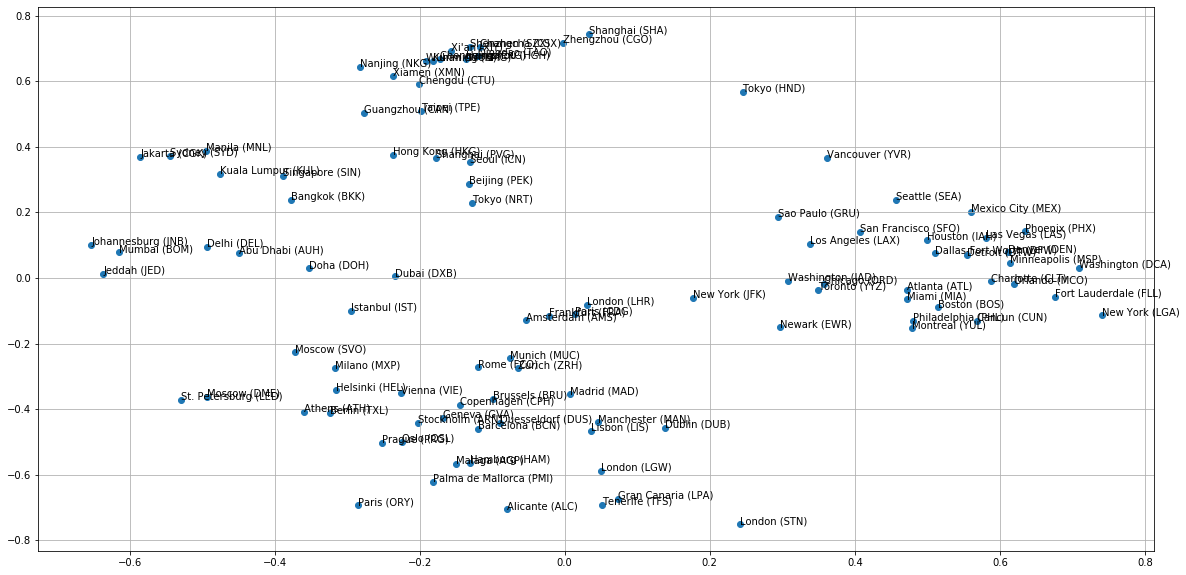

In [8]:
plt.figure(figsize=(20,10))
plt.scatter(embeddings[:, 0], embeddings[:, 1], marker='o')

for i, e in enumerate(embeddings):
    idx = sorted_idx[i]
    airport_code = id2airport[idx]
    city = airport2city[airport_code]
    plt.annotate('{} ({})'.format(city, airport_code), e)

plt.grid(True)
plt.show()

As we see, airports and cities geographically closer tend to cluster together in this embedding. This hints towards a higher number of flight connections between the geographically closer airports. This embedding therefore seems to be semantically doing the right thing.

In [9]:
mds.stress_

383.01480120150336

# Bridging MDS and PCA

In [10]:
# trying this with PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
weights_major.shape

(100, 100)

In [12]:
weights_major.shape

(100, 100)

In [13]:
pca = PCA(n_components=2)
pca = pca.fit(weights_major)
pca_compressed = pca.transform(weights_major)

In [14]:
pca_plot = pca_compressed

In [15]:
pca_plot.shape

(100, 2)

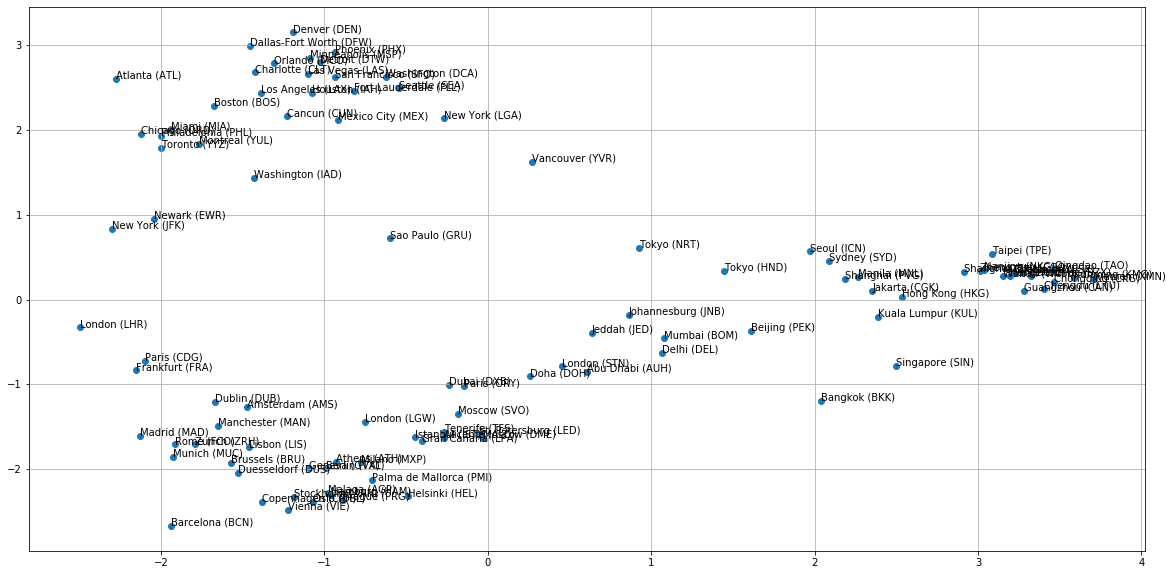

In [16]:
plt.figure(figsize=(20,10))
plt.scatter(pca_plot[:, 0], pca_plot[:, 1], marker='o')

for i, e in enumerate(pca_plot):
    idx = sorted_idx[i]
    airport_code = id2airport[idx]
    city = airport2city[airport_code]
    plt.annotate('{} ({})'.format(city, airport_code), e)

plt.grid(True)
plt.show()

# bonus: More PCA

In [17]:
sorted_idx

array([ 165, 2128, 2200, ..., 1556, 1482, 3030])

In [18]:
most_connected_airports = airports[['Latitude', 'Longitude', 'Altitude']].values[sorted_idx[:100], :]
norm_most_connected_airports = StandardScaler().fit_transform(most_connected_airports)

pca = PCA(n_components=2)
pca = pca.fit(norm_most_connected_airports)
compressed_most_connected_airports = pca.transform(norm_most_connected_airports)

In [19]:
compressed_most_connected_airports.shape

(100, 2)

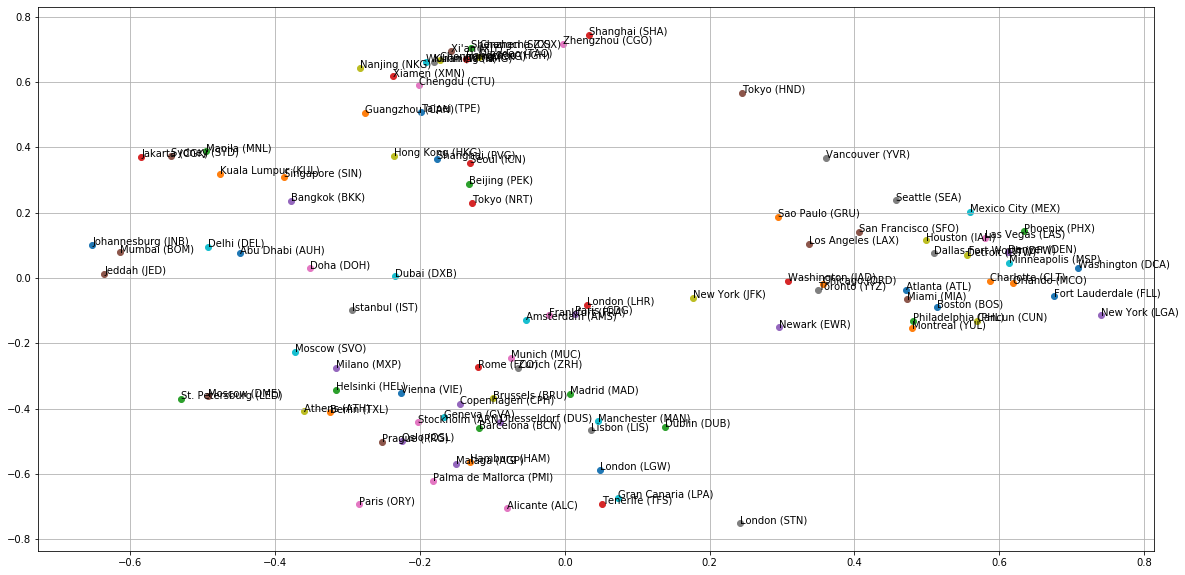

In [20]:
plt.figure(figsize=(20,10))
#plt.scatter(compressed_most_connected_airports[:, 0], compressed_most_connected_airports[:, 1], marker='o')

for i, (e_pca, e_mds) in enumerate(zip(compressed_most_connected_airports, embeddings)):
    combo = np.vstack((e_pca, e_mds))
    #plt.plot(combo[:,0], combo[:,1], '-o')
    #plt.scatter(e_pca[0], e_pca[1])
    plt.scatter(e_mds[0], e_mds[1])
    idx = sorted_idx[i]
    airport_code = id2airport[idx]
    city = airport2city[airport_code]
    plt.annotate('{} ({})'.format(city, airport_code), e_mds)

plt.grid(True)
plt.show()

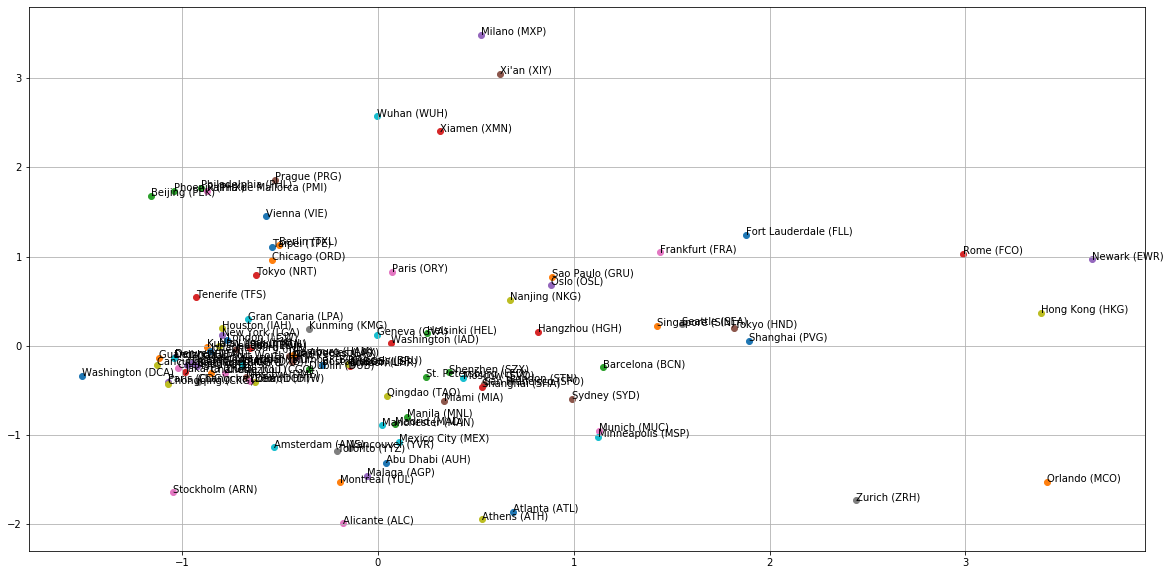

In [21]:
plt.figure(figsize=(20,10))
#plt.scatter(compressed_most_connected_airports[:, 0], compressed_most_connected_airports[:, 1], marker='o')

for i, (e_pca, e_mds) in enumerate(zip(compressed_most_connected_airports, embeddings)):
    combo = np.vstack((e_pca, e_mds))
    #plt.plot(combo[:,0], combo[:,1], '-o')
    plt.scatter(e_pca[0], e_pca[1])
    #plt.scatter(e_mds[0], e_mds[1])
    idx = sorted_idx[i]
    airport_code = id2airport[idx]
    city = airport2city[airport_code]
    plt.annotate('{} ({})'.format(city, airport_code), e_pca)

plt.grid(True)
plt.show()

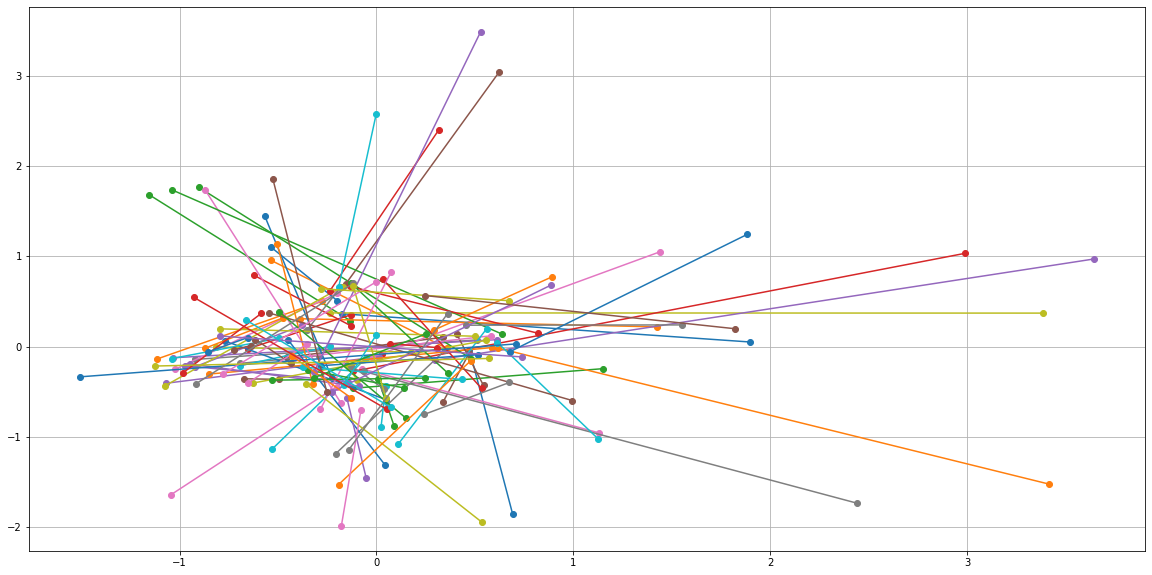

In [22]:
plt.figure(figsize=(20,10))
#plt.scatter(compressed_most_connected_airports[:, 0], compressed_most_connected_airports[:, 1], marker='o')

for i, (e_pca, e_mds) in enumerate(zip(compressed_most_connected_airports, embeddings)):
    combo = np.vstack((e_pca, e_mds))
    plt.plot(combo[:,0], combo[:,1], '-o')
    #plt.scatter(e_pca[0], e_pca[1])
    #plt.scatter(e_mds[0], e_mds[1])
    idx = sorted_idx[i]
    airport_code = id2airport[idx]
    city = airport2city[airport_code]
    #plt.annotate('{} ({})'.format(city, airport_code), e_pca)

plt.grid(True)
plt.show()

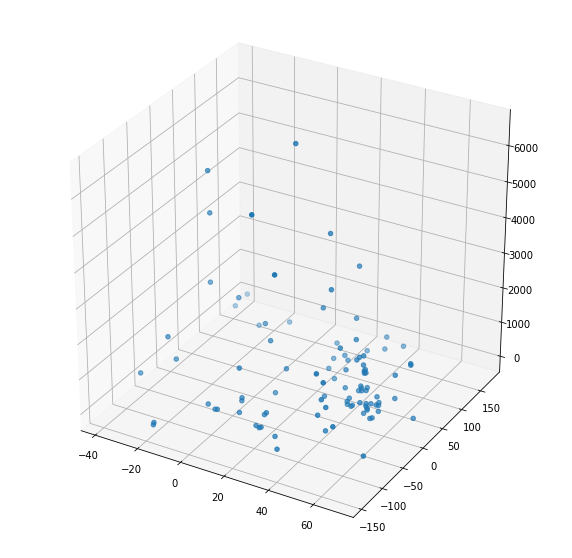

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(most_connected_airports[:, 0], most_connected_airports[:, 1], most_connected_airports[:, 2], marker='o')


plt.grid(True)
plt.show()